In [10]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
import xarray as xr
#import pandas as pd
#import matplotlib as mpl
#import openpyxl
#from mpl_toolkits.basemap import Basemap
#import matplotlib.pyplot as plt
import numpy as np
#from math import cos, radians
import datetime as dt
import os
from os.path import exists
import matplotlib.pyplot as plt

dir_cmc='F:/data/sst/cmc/CMC0.2deg/v2/'
dir_cmc_clim='F:/data/sst/cmc/CMC0.2deg/v2/climatology/'
dir_clim='F:/data/sat_data/oscar/L4/oscar_third_deg/climatology/'
dir_data = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/'
dir_figs = 'F:/data/NASA_biophysical/figures/'
dir_timeseries = 'F:/data/NASA_biophysical/timeseries_data/'

boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2']
boxes_lon_min = [-160,-130,-125,-130,-148]
boxes_lon_max = [-170,-140,-135,-140,-158]
boxes_lat_min = [41,46,35,52,52]
boxes_lat_max = [46,51,40,57,57]
boxes_lon_min_180 = boxes_lon_min[:]
boxes_lon_max_180 = boxes_lon_max[:]
for i in range(0,5):
    boxes_lon_min[i] += 360
    boxes_lon_max[i] += 360

#trying to get into xarray properly
location_values = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2']
data = [-160,-130,-125,-130,-148]
lon1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [-170,-140,-135,-140,-158]
lon2 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [41,46,35,52,52]
lat1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [46,51,40,57,57]
lat2 = xr.DataArray(data, coords=[location_values], dims=['location'])
boxes = xr.Dataset({'lon_min':lon1,'lon_max':lon2,'lat_min':lat1,'lat_max':lat2})
#boxes2 = xr.Dataset({'lon_min': (('location'), lon1),
#                 'lon_max': (('location'), lon2)},
#                { 'location': location_values})


def get_climatology(data_type):
    if data_type=='oscar':
#        filename = 'F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc'        
        filename = 'F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc'        
    if data_type=='sss':
        filename = 'F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_monthly_1993_2017_mercatorglorys12v1_gl12_mean.nc'
    if data_type=='sst':
        filename = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/monthly_climatology_1992_2016_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = 'F:/data/sat_data/ccmp/v02.0/1998_2017_monthly_climatology_ccmp_V02.0_L3.5_RSS.nc'
    return filename

def get_data(data_type,lyr):
    if data_type == 'oscar':
        dir_data = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
        filename = dir_data + str(lyr) + 'monthly_data_oscar.nc'
    if data_type=='sss':
        dir_data='F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/'
        fname_tem=str(lyr) + '/'+ 'year_subset_mercatorglorys12v1_gl12_mean_' + str(lyr) + '.nc'
        filename = dir_data + fname_tem
    if data_type=='sst':
        dir_data = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/' 
        filename = dir_data + str(lyr) + 'monthly_average_' + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        dir_data='F:/data/sat_data/ccmp/v02.0/'
        filename = dir_data + str(lyr) + 'monthly_average_ccmp_V02.0_L3.5_RSS.nc'
    return filename


In [7]:
#make oscar timeseries
#for ibox in range(0,2): #5):
#dtype='ccmp'
#dtype='oscar'
dtype='sst'
#dtype='sss'

for i in range(0,5):
    for lyr in range(2000,2018):
        filename = get_data(dtype,lyr)
        if os.path.exists(filename):  
            print(filename)
            ds=xr.open_dataset(filename)
            if dtype=='ccmp':
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            elif dtype=='oscar':
                ds = ds.drop('year')
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
            else:
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i],boxes.lon_min[i]),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            ds.close()       
            ds_mean = ds_subset.mean('lat').mean('lon')   
#get climatology
            filename = get_climatology(dtype)
            ds = xr.open_dataset(filename)
            if dtype=='ccmp':
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            elif dtype=='oscar':
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
            else:
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i],boxes.lon_min[i]),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            ds.close()       
            ds_mean_clim = ds_subset.mean('lat').mean('lon')   
            
            ds_diff = ds_mean.groupby('time.month') - ds_mean_clim
            if lyr==2000:
                ds_box = ds_mean
                ds_box_clim = ds_diff
            else:
                ds_box = xr.concat([ds_box,ds_mean],dim='time')
                ds_box_clim = xr.concat([ds_box_clim,ds_diff],dim='time')
        #print(box)
    if i==0:
        ds_newbox = ds_box
        ds_newbox_clim = ds_box_clim
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        ds_newbox_clim = xr.concat([ds_newbox_clim,ds_box_clim],dim='box')
        #print(ds_newbox.box)
filename_out = dir_timeseries + dtype + 'data.nc'
ds_newbox.to_netcdf(filename_out)
filename_out_clim = dir_timeseries + dtype + 'data_minus_clim.nc'
ds_newbox_clim.to_netcdf(filename_out_clim)
print('out!')
#        ds_subset['tot_vel']=(ds_subset.u**2+ds_subset.v**2)**.5       
#        ds_subset['tot_vel_var']=ds_subset.tot_vel**2      
#        ds_subset['u_sq']=ds_subset.u**2       
#        ds_subset['v_sq']=ds_subset.v**2      
#        ds_mean = ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    


F:/data/sst/cmc/CMC0.2deg/v2/monthly/2000monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2001monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2002monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2003monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2004monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2005monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2006monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2007monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2008monthly_average_120000-CMC-L4_G

F:/data/sst/cmc/CMC0.2deg/v2/monthly/2017monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2000monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2001monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2002monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2003monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2004monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2005monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2006monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2007monthly_average_120000-CMC-L4_G

PermissionError: [Errno 13] Permission denied: b'F:\\data\\eddy\\timeseries_data\\sstdata.nc'

In [9]:
filename_out

'F:/data/eddy/timeseries_data/sstdata.nc'

In [ ]:
i=4
lyr = 2005
dtype = 'oscar'
filename = get_data(dtype,lyr)
ds=xr.open_dataset(filename)
ds_drop = ds.drop('year')
ds_subset = ds_drop.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
ds_subset['spd'] = (ds_subset.u**2+ds_subset.v**2)**.5
ds_mean = ds_subset.mean('lat').mean('lon') 
filename = get_climatology(dtype)
ds = xr.open_dataset(filename)
ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
ds_subset['spd'] = (ds_subset.u**2+ds_subset.v**2)**.5
ds_mean_clim = ds_subset.mean('lat').mean('lon')   
ds_diff = ds_mean.groupby('time.month') - ds_mean_clim


In [ ]:
#ds_mean.so.plot()
#ds_diff = ds_mean.groupby('time.month') - ds_mean_clim
#ds_diff.so.plot()
#ds_mean_clim.so.plot()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ds_newbox.time[:],ds_newbox.so[0,:]-33.2)
plt.plot(ds_newbox.time[:],ds_newbox_clim.so[0,:])
#plt.plot(ds_newbox.time[:],ds_newbox_clim.so[0,:,0])

In [16]:
#filename_out_clim = dir_timeseries + dtype + 'data_minus_clim.nc'
data_type= 'data.nc'
data_type2= 'data_minus_clim.nc'
dtype = 'oscar'
filename = dir_timeseries + dtype + data_type
ds_oscar = xr.open_dataset(filename)
ds_oscar.close()
filename = dir_timeseries + dtype + data_type2
ds_oscar_clim = xr.open_dataset(filename)
ds_oscar_clim.close()
dtype = 'sst'
filename = dir_timeseries + dtype + data_type
ds_sst = xr.open_dataset(filename)
ds_sst.close()
filename = dir_timeseries + dtype + data_type2
ds_sst_clim = xr.open_dataset(filename)
ds_sst_clim.close()
dtype = 'ccmp'
filename = dir_timeseries + dtype + data_type
ds_ccmp = xr.open_dataset(filename)
ds_ccmp.close()
filename = dir_timeseries + dtype + data_type2
ds_ccmp_clim = xr.open_dataset(filename)
ds_ccmp_clim.close()
dtype = 'sss'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'sss', dir_timeseries + dtype + data_type
ds_sss = xr.open_dataset(filename)
ds_sss.close()
filename = dir_timeseries + dtype + data_type2
ds_sss_clim = xr.open_dataset(filename)
ds_sss_clim.close()


In [17]:
ds_ccmp

<xarray.Dataset>
Dimensions:  (box: 5, time: 216)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15 2000-02-15 ... 2017-12-15T21:00:00
Dimensions without coordinates: box
Data variables:
    uwnd     (box, time) float32 ...
    vwnd     (box, time) float32 ...
    spd      (box, time) float32 ...
    dir      (box, time) float32 ...

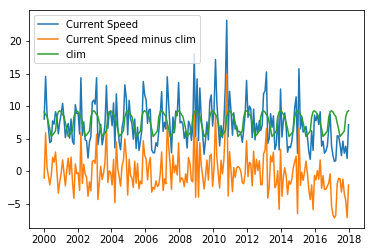

In [18]:
plt.plot(ds_ccmp.time[:],ds_ccmp.spd[0,:],label = 'Current Speed')
plt.plot(ds_ccmp.time[:],ds_ccmp_clim.spd[0,:], label = 'Current Speed minus clim')
plt.plot(ds_ccmp.time,ds_ccmp.spd[0,:]-ds_ccmp_clim.spd[0,:],label = 'clim')
plt.legend()

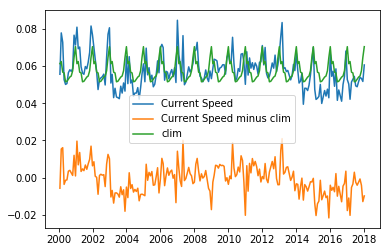

In [7]:

plt.plot(ds_oscar.time[:],ds_oscar.spd[0,:],label = 'Current Speed')
plt.plot(ds_oscar.time[:],ds_oscar_clim.spd[0,:], label = 'Current Speed minus clim')
plt.plot(ds_oscar.time,ds_oscar.spd[0,:,0]-ds_oscar_clim.spd[0,:,0],label = 'clim')
plt.legend()

In [19]:
ds_sst

<xarray.Dataset>
Dimensions:  (box: 5, depth: 1, time: 216)
Coordinates:
  * depth    (depth) float32 15.0
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2017-12-31
Dimensions without coordinates: box
Data variables:
    u        (box, time, depth) float64 ...
    v        (box, time, depth) float64 ...

In [ ]:
ds=ds_sst
ds_clim = ds_sst_clim
plt.plot(ds.time[:],ds.spd[0,:],label = 'Current Speed')
plt.plot(ds.time[:],ds_clim.spd[0,:], label = 'Current Speed minus clim')
plt.plot(ds.time,ds.spd[0,:,0]-ds_clim.spd[0,:,0],label = 'clim')
plt.legend()


In [ ]:
min(ds_cmc.time[:])

In [ ]:
import matplotlib.pyplot as plt
#        fig,ax = plt.subplots(1)
plt.figure(figsize=(6, 8))
for i in range(0,5):
    plt.subplot(5, 1, i+1)
    plt.plot(ds_oscar.time[:],ds_oscar.tot_vel[i,:,0])
    #plt.text(2012,0.1,str(boxes_names[i]), fontsize=12)
    plt.ylim([0.03,0.15])
#    if i<4:
#        plt.set_xticklabels([])
    if i==4:
        plt.xlabel('Date')
    if i==2:
        plt.ylabel('Total Current (cm s$^{-1}$)')
    #plt.plot(ds_cmc.time[:],ds_cmc.analysed_sst[i,:]-273.15,'r')
fig_fname=dir_figs+"boxes_oscar.png"
#fig_fname=dir_figs+"boxes_sst.png"
plt.savefig(fig_fname, transparent=False, format='png')
plt.show()
print(fig_fname)

In [ ]:
#filename_oscar_clim = dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc'
filename_TS_out = 'F:/data/eddy/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
#make cmc timeseries
#for ibox in range(0,2): #5):
inc=-1
for box in boxes_names:
    inc+=1 
    for lyr in range(2000,2017):
        syr=str(lyr).zfill(4)
        fname_tem='monthly_average_' + syr + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
        cmc_filename_out = dir_cmc + syr + fname_tem
        ds=xr.open_dataset(cmc_filename_out)
        ds_subset = ds.sel(lon=slice(boxes_lon_max_180[inc],boxes_lon_min_180[inc]),lat=slice(boxes_lat_min[inc],boxes_lat_max[inc])) 
        ds.close()
 #       ds_mean = ds_subset #ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    
        ds_mean = ds_subset.mean('lat').mean('lon')
        if lyr==2000:
            ds_box = ds_mean
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='time')
        #print(box)
    if box=='NPC':
        ds_newbox = ds_box
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        #print(ds_newbox.box)
ds_newbox.to_netcdf(filename_TS_out)

In [ ]:
#ds
#ds_subset.analysed_sst[0,:]
#boxes_lon_max_180
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.analysed_sst